In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import *
from pyspark.sql.functions import lower, col
from pyspark.sql import SQLContext, Row
import re
import string
import fasttext as ft
from sklearn.model_selection import train_test_split
import tweepy
from nltk.corpus import stopwords
import nltk
import operator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud, STOPWORDS 
import time
import pandas as pd


conf = (SparkConf()
         .setMaster("local")
         .setAppName("My app")
         .set("spark.executor.memory", "1g"))
sc = SparkContext(conf = conf)

#                       ------------- MAIN IMPLEMENTATION --------------

In [40]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

classifier_restored = ft.load_model("tweet_model.bin", label_prefix='__label__')

stopwords_list = stopwords.words('english')

def stream_tweet(hashtag):
    tweets = []
    statuses = tweepy.Cursor(api.search, q=hashtag+" -filter:retweets", rpp=100, lang = "en",show_user=False).items(1000)
    tweets = [(s.text, s.created_at, s.entities, s.favorite_count, s.retweet_count, s.source)for s in statuses]
    return tweets
def remove_punctuation(input_text):
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')
    return input_text.translate(trantab)
def remove_urls(input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
def remove_digits(input_text):
    return re.sub('\d+', '', input_text)
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

In [45]:
def main():
    import time
    hashtag = input("Please enter the hashtag for tweeter search: ")
    qword = hashtag
    if hashtag[0] != "#":
        hashtag = "#" + hashtag
    
    a = True
    while a == True:
        try:
            minedtweets = stream_tweet(hashtag)
            a = False
        except tweepy.TweepError as e:
            e1 = "'code': 88" in str(e)
            e2 = "code = 429" in str(e)
            if e1 == True:
                print ("Have rate limit error, waiting 6 min.")
                time.sleep(60*6)
            elif e2 == True:
                print ("Have rate limit error, waiting 6 min.")
                time.sleep(60*6)
                        
    print("Got",str(len(minedtweets)),"tweets with "+hashtag +" for analysis.")
    testdatafreqword = {}
    for item in minedtweets:
        for hashtag in item[2]['hashtags']:
            if hashtag['text']:
                lower_hashtag = hashtag['text'].lower()
                if lower_hashtag in testdatafreqword:
                    testdatafreqword[lower_hashtag] +=1
                else:
                    testdatafreqword[lower_hashtag] = 1
    testdatafreqword = sorted(testdatafreqword.items(), key=operator.itemgetter(1))
    #Freq hashtag word defined here..
    datafreqhashtag = testdatafreqword[-100:]
    
    sourcedevices = {}
    for item in minedtweets:
        device = item[5]
        if device in sourcedevices:
            sourcedevices[device] += 1
        else:
            sourcedevices[device] = 1
    sourcedevices = sorted(sourcedevices.items(), key=operator.itemgetter(1))
    #Source device information defined here..
    
    testdatatraffic = {}
    for item in minedtweets:
        date = item[1]
        hour = str(date)
        hour = hour [11:13]

        if hour in testdatatraffic:
            testdatatraffic[hour] += 1
        else:
            testdatatraffic[hour] = 1
    testdatatraffic = sorted(testdatatraffic.items(), key=operator.itemgetter(0))
    #Traffic information defined here..
    datatraffic = testdatatraffic[-10:]
    
    #Average RT Count..
    avgrtcount = 0
    for item in minedtweets:
        avgrtcount += item[4]
    avgrtcount = avgrtcount / len(minedtweets)
    
    #Average Fav Count..
    avgfavcount = 0
    for item in minedtweets:
        avgfavcount += item[3]
    avgfavcount = avgfavcount / len(minedtweets)
    
    #Average Mention Count..
    avgmenionrate = 0
    for item in minedtweets:
        avgmenionrate += len(item[2]['user_mentions'])
    totalmentioncount = avgmenionrate
    avgmenionrate = avgmenionrate / len(minedtweets)
    
    clean_tweet_list = []

    for item in minedtweets:
        tweet = item[0]
        #remove mention
        tweet = remove_mentions(tweet)
        #remove url
        tweet = remove_urls(tweet)
        #remove emoji
        tweet = deEmojify(tweet)
        #remove punctuation
        tweet = remove_punctuation(tweet)
        #set lower
        tweet = tweet.lower()
        #remove digit
        tweet = remove_digits(tweet)
        tweet = tweet.replace("\n"," ")
        clean_tweet_list.append(tweet)
    all_clean_list = list(dict.fromkeys(clean_tweet_list))
    
    #Sentiment Results of query.
    sentiment_list = []
    for item in all_clean_list:
        labels = classifier_restored.predict(item)
        sentiment_list.append(labels[0][0])
    
    testdatawordcloud = {}
    alist = []
    for item in all_clean_list:
        tokens = nltk.word_tokenize(item)
        for k in tokens:
            if not k in stopwords_list:
                if len(k) != 1:
                    alist.append((k,1))
    
    rdd = sc.parallelize(alist)
    hello = rdd.reduceByKey(lambda x,y: x+y).sortBy(lambda a: a[1],ascending=False)
    #Wordcloud defined here..
    wordcloud = hello.collect()
        
    a1 = {}
    for item in datafreqhashtag:
        a1["#"+item[0]] = item[1]
    del a1["#"+qword]
    wc = WordCloud(background_color="white",width=3000,height=1000, max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(a1)
    plt.figure(figsize=(14,7))
    plt.imshow(wc)
    plt.axis('off')
    plt.title("----Most Frequent Hashtags---- \n",fontsize="25")
    
    b1 = []
    b2 = []
    summ = 0
    for i in range(1,len(sourcedevices)):
        if i < 6:
            b1.append(sourcedevices[-i][0])
            b2.append(sourcedevices[-i][1])
        else:
            summ = (sourcedevices[-i][1]) + summ
    b1.append("Others")
    b2.append(summ)
    plt.figure(figsize=(7,7))
    plt.pie(b2, labels=b1,autopct='%1.1f%%',textprops=dict(fontsize="15"))
    plt.title("Source Platforms",fontsize="25")
    
    time = []
    values = []
    for item in datatraffic:
        time.append(item[0]+":00")
        values.append(item[1])
    plt.figure(figsize=(6,4))
    plt.plot(time,values)
    plt.title("Tweet Traffic",fontsize="20")
    plt.show()
    
    print("-----------------------------------------")
    print("Average RT Count: " + str(avgrtcount))
    print("Average Fav Count: " + str(avgfavcount))
    print("Average Mention Count: " + str(avgfavcount))
    print("-----------------------------------------")

    count=0
    for item in sentiment_list:
        if item =="positive":
            count=count+1
    pielist= []
    prob_of_1=(100*count)/len(sentiment_list)
    pielist.append(prob_of_1)
    pielist.append(100-prob_of_1)
    plt.figure(figsize=(7,7))
    plt.title("Sentiment Analysis",fontsize="20")
    plt.pie(pielist, labels=["Positive","Negative"],autopct='%1.1f%%',colors=["green","gray"],textprops=dict(fontsize="15"))

    h1 = {}
    for item in wordcloud:
        h1[item[0]] = item[1]
    del h1[qword]
    wc = WordCloud(background_color="white",width=3000,height=1000, max_words=100,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(h1)
    plt.figure(figsize=(14,7))
    plt.imshow(wc)
    plt.axis('off')
    plt.title("----Most Frequent Words In Tweets---- \n",fontsize="25")

Please enter the hashtag for tweeter search: apple
Got 1000 tweets with #apple for analysis.


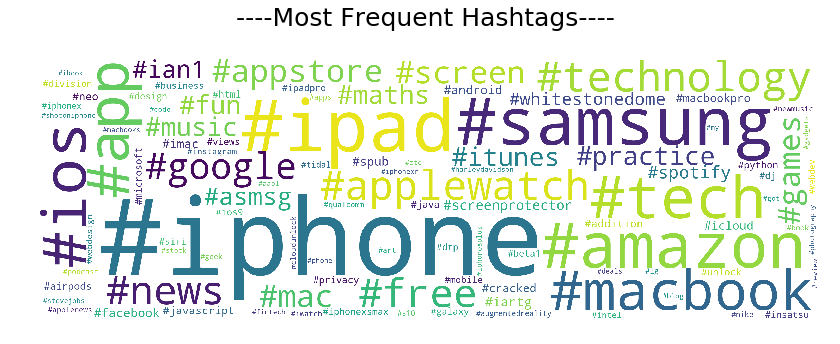

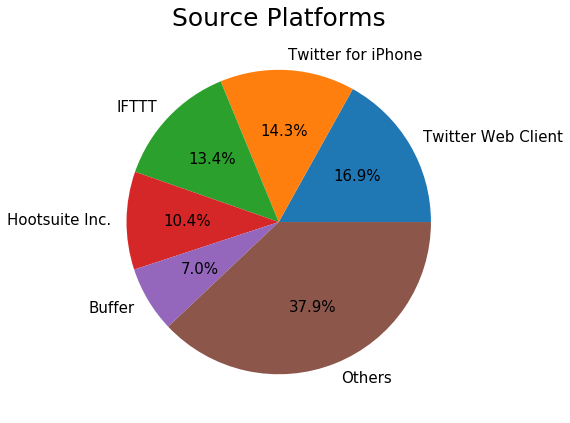

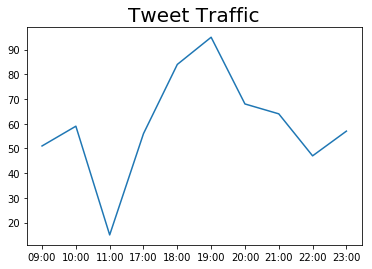

-----------------------------------------
Average RT Count: 0.434
Average Fav Count: 1.031
Average Mention Count: 1.031
-----------------------------------------


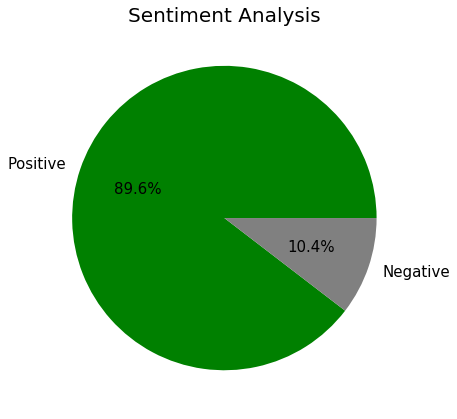

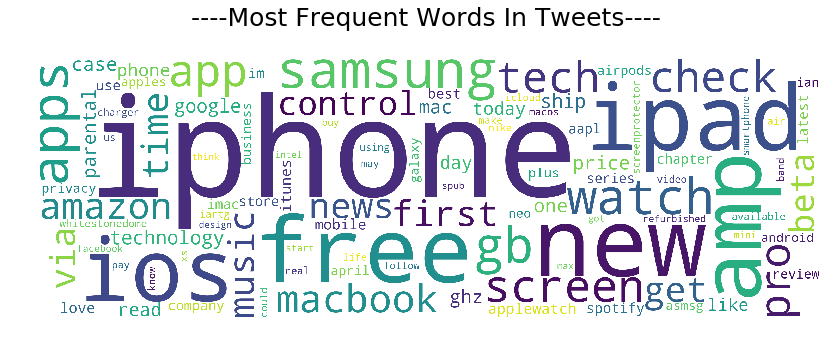

In [51]:
main()